In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

from face_tally.ml_logic.image_prediction import predict_bounding_boxes, crop_image
from face_tally.params import *
from face_tally.ml_logic.model import get_model
from rembg import remove
import os
from deepface import DeepFace


/home/matias/.pyenv/versions/3.10.6/envs/facetally/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-07 10:58:47.073406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 10:58:47.073471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 10:58:47.076202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [3]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
images_path = os.path.join(parent_path, 'images')


backgrounds = {
    "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
    "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
    "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
    "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
    "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
    "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
    "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
}

genres = {
    "warrior": Image.open(os.path.join(images_path, 'warrior.png')),
    "princess": Image.open(os.path.join(images_path, 'princess.png'))
}


In [137]:
def get_images():
    current_path = os.getcwd()
    parent_path = os.path.dirname(current_path)
    images_path = os.path.join(parent_path, 'images')


    backgrounds = {
        "happy": Image.open(os.path.join(images_path, 'backround_happy.jpg')),
        "angry": Image.open(os.path.join(images_path, 'backround_angry.jpg')),
        "sad": Image.open(os.path.join(images_path, 'backround_sad.jpg')),
        "neutral": Image.open(os.path.join(images_path, 'backround_neutral.jpg')),
        "fear": Image.open(os.path.join(images_path, 'backround_fear.jpg')),
        "disgust": Image.open(os.path.join(images_path, 'backround_disgust.jpg')),
        "surprise": Image.open(os.path.join(images_path, 'backround_surprise.jpg'))
    }

    pics = {
        "Man": Image.open(os.path.join(images_path, 'warrior.png')),
        "Women": Image.open(os.path.join(images_path, 'princess.png')),
        "heart": Image.open(os.path.join(images_path, 'heart.png'))
    }

    return backgrounds, pics


In [98]:
def get_biggest_bounding_box(bbox):
    """
    Given a bounding box list, it returns a new bounding box list with the
    biggest bounding box in it. The biggests bbox is the one with the biggest
    area. Returns an empty list if the input is empty
    """

    biggest_face_area = 0
    biggest_face = None
    biggest_bbox = []
    for face in bbox:
        coordinates = face["Coordinates"]
        face_area = abs(coordinates[2] - coordinates[0]) * abs(coordinates[3] - coordinates[1])
        if face_area >= biggest_face_area:
            biggest_face = face
            biggest_face_area = face_area

    if biggest_face is not None:
        biggest_bbox.append(biggest_face)

    return biggest_bbox


In [144]:
def draw_image(results, person_array):

    backgrounds, pics = get_images()
    person = Image.fromarray(person_array)

    # Getting the results from the preictions
    background = backgrounds[results[0]["dominant_emotion"]]
    energy = pics[results[0]["dominant_gender"]]
    heart = pics["heart"]
    age = results[0]['age']


    #Create the image:
    text_img = Image.new('RGBA', (600,600), (0, 0, 0, 0))

    #Paste the background:
    background_resized = background.resize((600, 600))
    text_img.paste(background_resized, (0,0))

    #Paste the heart conditional to the age of the person:
    heart_resized = heart.resize((50,50))
    text_img.paste(heart_resized, ((int(180 + (age / 100) * (450 - 180)), 470)), mask = heart_resized)

    #Writing the age of the person:
    draw = ImageDraw.Draw(text_img) # Crear un objeto ImageDraw para dibujar en la imagen
    font = ImageFont.load_default(55) # Especificar la fuente y el tamaño del texto
    text_position = (30, 450) # Especificar la posición y el contenido del texto
    text_content = f"{age}"
    draw.text(text_position, text_content, font=font, fill=(0, 0, 0, 0))

    #Paste the energy (gender) of the person:
    energy = energy.resize((120,120))
    text_img.paste(energy, (30,70), mask=energy)

    # Taking care of the person

    # Define the desired coordinates
    x_min, x_max = 190, 410
    y_min, y_max = 80, 370
    # draw.text((x_min, y_min), "_", font=font, fill=(0, 0, 0, 0))
    # draw.text((x_max, y_max), "_", font=font, fill=(0, 0, 0, 0))

    # Calculate the new dimensions while maintaining proportions
    original_width, original_height = person.size
    new_width = x_max - x_min # Ensure the width doesn't exceed the available space
    new_height = int((new_width * original_height) / original_width)

    # Calculate the y-coordinate to ensure it stays within the specified range
    y_coordinate = y_max - new_height
    # Resize the person image with the new dimensions
    person_resized = person.resize((new_width, new_height))
    # Paste the person_resized image with the adjusted coordinates
    text_img.paste(person_resized, (x_min, y_coordinate), mask=person_resized)

    return text_img


In [5]:
model, _ = await get_model(MODEL_SOURCE)


✅ Loaded weights from the comet ML


In [130]:
character = Image.open('trial_images/football_try.jpeg')
character_array = np.array(character)


In [131]:
bbs = predict_bounding_boxes(character_array, model, "COMET")
bb = get_biggest_bounding_box(bbs)
face = crop_image(character_array, bb)



0: 320x640 3 0s, 172.4ms
Speed: 3.3ms preprocess, 172.4ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
(465, 948, 3)


In [132]:
results = DeepFace.analyze(face, actions=["emotion", "age", "gender"])


Action: gender: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s] 


In [139]:
person_array = remove(face)


In [145]:
text_img = draw_image(results, person_array)


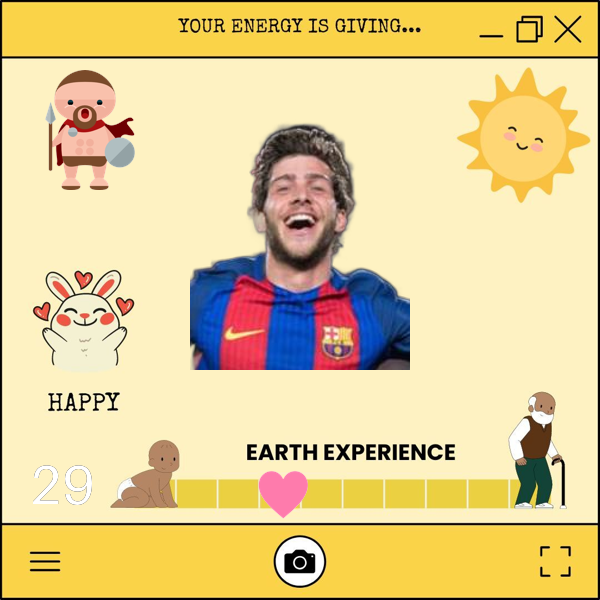

: 

In [146]:
text_img
